In [11]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize
import defmod.save_results as results

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data = regdata.Nut()
data()
source = data.source
target = data.target
module_list = data.modules
reduce_background = False

In [13]:
data = regdata.Nut_translated(source_transvec=[0.,0.], target_transvec=[0.,0.], reflect_target=-1.)
data()
source = data.source
target = data.target
module_list = data.modules
reduce_background = False

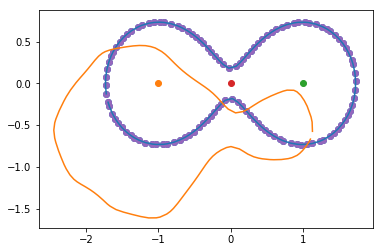

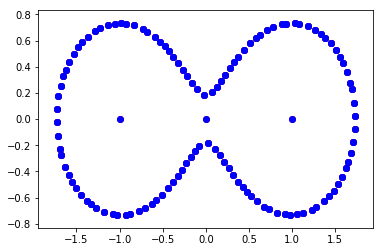

In [14]:
plt.figure()
for i in range(1):
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1])
    for j in range(5):
        plt.scatter(module_list[0][j].manifold.gd.view(-1,2).detach().numpy()[:,0],module_list[0][j].manifold.gd.view(-1,2).detach().numpy()[:,1])



plt.plot(target[0].detach().numpy()[:,0], target[0].detach().numpy()[:,1])
#plt.plot(target[1].detach().numpy()[:,0], target[1].detach().numpy()[:,1])


plt.figure()
for gd in data.modules[0].manifold.gd:
    plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='r')
for gd in data.modules[0].manifold.gd:
    plt.scatter(gd.view(-1,2).detach().numpy()[:,0],gd.view(-1,2).detach().numpy()[:,1], c='b')

plt.show()

In [15]:
h = dm.hamiltonian.Hamiltonian(data.modules)
def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[0].manifold.gd.view(-1,2) for i in range(len(target))], target)
E = EnergyFunctional_unconstrained(h.module, h, source, target, dim=2, gamma=0.01, attach=attach)

In [16]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(h.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
X[1], iter_states = optimize.BFGS(E, X, disp=True)(maxiter=100)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 12.932866485633268
cost: 0.0 attach: 12.932866485633268
cost: 0.25142427013593094 attach: 38.18460159651174
cost: 0.25142427013593094 attach: 38.18460159651174
cost: 0.011234335428553583 attach: 7.835381861165004
cost: 0.011234335428553583 attach: 7.835381861165004
cost: 0.04177110548609626 attach: 10.635297119594519
cost: 0.04177110548609626 attach: 10.635297119594519
cost: 0.017269755602519647 attach: 5.368949167250077
cost: 0.017269755602519647 attach: 5.368949167250077
cost: 0.041097573714616066 attach: 11.400296977592173
cost: 0.041097573714616066 attach: 11.400296977592173
cost: 0.019063803344558494 attach: 4.795288698227785
cost: 0.019063803344558494 attach: 4.795288698227785
cost: 0.02650683412965485 attach: 7.955226760441231
cost: 0.02650683412965485 attach: 7.955226760441231
cost: 0.019450747704941502 attach: 4.728599676136083
cost: 0.019450747704941502 attach: 4.728599676136083
cost: 0.01950588483239826 attach: 4.596040283934842
cost: 0.01950588483239826 at

In [ ]:

h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1])
save = results.Save_Results_SingleShape(h, source, target)

save.fig_states(show=True)

In [ ]:
save.fig_states(show=True, plot_controls=True)

In [ ]:
xlim = [-3, 3]
ylim = [-3,3]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

#fig_states = save.fig_states(show=True)
fig_grid = save.fig_grid(True)

save.save('../results/Nut/Defmod/')
plt.close('all')

In [ ]:
## LDDMM Module

man = dm.manifold.Landmarks(2, len(source[0]), gd = source[0].view(-1))
man_landmarks = dm.manifold.Landmarks(2, 3, gd = torch.tensor([[-1.,0.],[0.,0.], [1.,0.]], requires_grad=True).view(-1))
silent_landmarks = dm.deformationmodules.SilentPoints(man_landmarks)
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man, sigma=0.2), silent_landmarks])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

reg_param = 1e-3
Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, source, target, dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=100)

In [ ]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-3, 3]
ylim = [-2,2]
d = [0.05, 0.05]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grid(True)

#save.save('../results/Nut/LDDMM/')
#plt.close('all')

In [ ]:
save.fig_states(True)

In [ ]:
save.fig_grid(True)

In [5]:
sigma_bg = 0.001
modules = dm.multishape.MultiShapeModule(data.modules, sigma_bg)
constr_Id = dm.constraints.Identity_Silent()
h = hamiltonian.Hamiltonian_multi(modules, constr_Id)

reg_param = 1e-3
def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules[0][0].manifold.gd.view(-1,2)], target)
E = EnergyFunctional_unconstrained(h.module, h, source, target, dim=2, gamma=reg_param, attach=attach)

In [6]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(h.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

X[1] = optimize.BFGS(E, X, disp=True)(maxiter=10, gtol=1e-5, eps=1e-8)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 12.932866485633268
cost: 0.0 attach: 12.932866485633268
cost: 0.0040943010106675795 attach: 6.451553987268154
cost: 0.0040943010106675795 attach: 6.451553987268154
cost: 0.02306019877902922 attach: 1.200828895910538e+25
cost: 0.02306019877902922 attach: 1.200828895910538e+25
cost: 0.008393895188944374 attach: 3.4966451074930482
cost: 0.008393895188944374 attach: 3.4966451074930482
cost: 0.018049404504363275 attach: 8.947173747887899
cost: 0.018049404504363275 attach: 8.947173747887899
cost: 0.011583542065626517 attach: 3.092875119825808
cost: 0.011583542065626517 attach: 3.092875119825808
cost: 0.012865451602980353 attach: 3.6011519820081954
cost: 0.012865451602980353 attach: 3.6011519820081954
cost: 0.011821834282583387 attach: 3.1632863249957213
cost: 0.011821834282583387 attach: 3.1632863249957213
cost: 0.011631542755530869 attach: 3.1068379421926444
cost: 0.011631542755530869 attach: 3.1068379421926444
cost: 0.011593303123716243 attach: 3.096021362596578
cost: 0.0

cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.0932594222509024
cost: 0.011583542065644091 attach: 3.0932594222509024
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532
cost: 0.011583542065644091 attach: 3.092752317505532


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.011583914901043806 attach: 3.0932970595657086
cost: 0.01158360036599545 attach: 3.093059485702203
cost: 0.01158357121579153 attach: 3.0932524650717674
cost: 0.011583556640710705 attach: 3.093337457109299
cost: 0.011583549353175713 attach: 3.093287462193177
cost: 0.011583545709409584 attach: 3.0932988258014458
cost: 0.01158354388752685 attach: 3.0933687237379033
cost: 0.011583542976585315 attach: 3.092711538577565
cost: 0.011583542976585315 attach: 3.092711538577565
cost: 0.01158354297557969 attach: 3.093234640569328
cost: 0.01158354297658564 attach: 3.093618822271571
cost: 0.011583542976585315 attach: 3.092711538577565
cost: 0.011583542976585315 attach: 3.092711538577565
         Current function value: 3.104336
         Iterations: 4
         Function evaluations: 98
         Gradient evaluations: 87


In [7]:
h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1][0])
h.geodesic_controls()

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


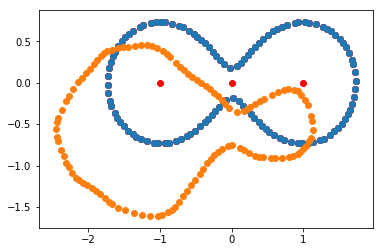

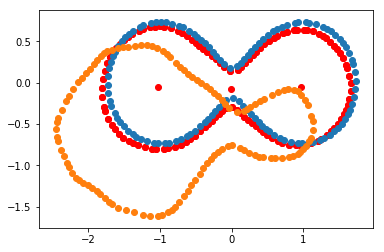

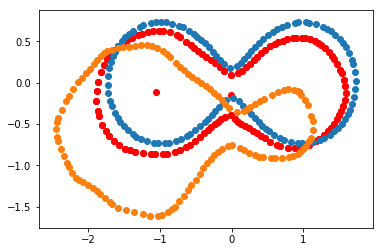

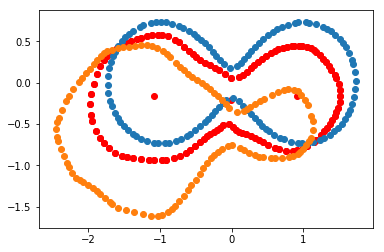

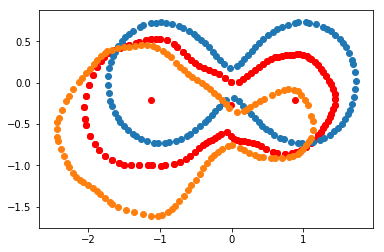

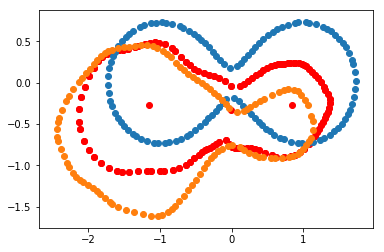

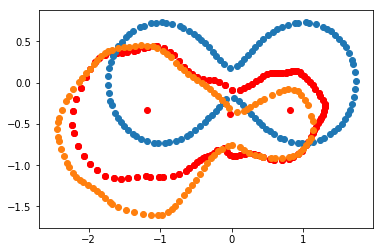

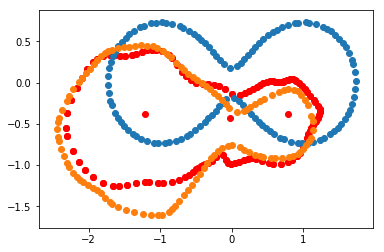

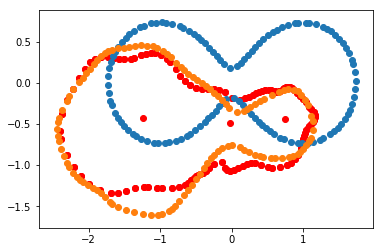

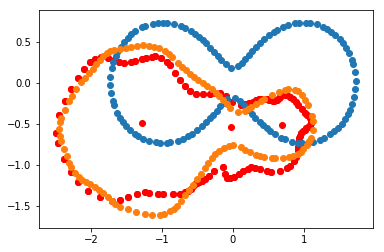

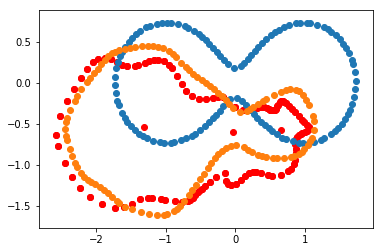

In [8]:

states, controls = dm.shooting.shoot_euler(h, it=10)


for s in states:
    plt.figure()
    for i in range(1):
        plt.scatter(s[i][0].gd.view(-1,2)[:, 0].detach().numpy(), s[i][0].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][1].gd.view(-1,2)[:, 0].detach().numpy(), s[i][1].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][2].gd.view(-1,2)[:, 0].detach().numpy(), s[i][2].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][3].gd.view(-1,2)[:, 0].detach().numpy(), s[i][3].gd.view(-1,2)[:, 1].detach().numpy(), c='r')
        plt.scatter(s[i][4].gd.view(-1,2)[:, 0].detach().numpy(), s[i][4].gd.view(-1,2)[:, 1].detach().numpy(), c='r')

    plt.scatter(source[0][:,0].detach().numpy(), source[0][:,1].detach().numpy())
    plt.scatter(target[0][:,0].detach().numpy(), target[0][:,1].detach().numpy())
plt.show()

In [ ]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i].module_list[0].manifold.gd.view(-1,2) for i in range(len(target))], target)

E = EnergyFunctional(H.module, H, constr_Id, source, target, dim=2, gamma=1., attach=attach)

In [ ]:
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=20)

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        h.module.manifold.fill_gd(gd)
        h.module.manifold.fill_cotan(mom)
        h.geodesic_controls()
        return h()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(h.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(h.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)

h = h
test_gradcheck_Hamiltonian()